## Find the number of gates and calculate the quantum cost of the circuit + a general Grover's algorithm code.
Here I intend to compare two code **Walid's** code and **Omar's** code on Grover's algorithm for searching a string of binary numbers by calculating the quantum cost of both circuits.

In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'Grover')))

In [7]:
from qiskit import *
from grover import *

### String to be found is '01011001'

In [8]:
################################## OMAR'S CODE ##################################
circuit=QuantumCircuit(16,8)
a=[0,1,2,3,4,5,6,7,15]
b=[0,1,2,3,4,5,6,7]
circuit.x(15)
circuit.h(a)
i=0
while i<12:
    i=i+1
    #oracle
    circuit.x([1,2,5,7])
    circuit.ccx(0,1,8)
    x=2
    y=8
    z=9
    while x<8:
        circuit.ccx(x,y,z)
        x=x+1
        y=y+1
        z=z+1
    circuit.cx(14,15)
    while x>2:
        x=x-1
        y=y-1
        z=z-1
        circuit.ccx(x,y,z)
    circuit.ccx(0,1,8)
    circuit.x([1,2,5,7])

    #grover diffusion operator
    circuit.h(b)
    circuit.x(b)
    circuit.ccx(0,1,8)
    x=2
    y=8
    z=9
    while x<8:
        circuit.ccx(x,y,z)
        x=x+1
        y=y+1
        z=z+1
    circuit.cx(14,15)
    while x>2:
        x=x-1
        y=y-1
        z=z-1
        circuit.ccx(x,y,z)
    circuit.ccx(0,1,8)  
    circuit.x(b)
    circuit.h(b)

circuit.measure(b,b)

### -Number of gate:
**Use the `count_ops()` method to harvest the number of operations in the circuit.**

In [9]:
########### Count the operators ###########
circuit.count_ops()

OrderedDict([('ccx', 336), ('x', 289), ('h', 201), ('cx', 24), ('measure', 8)])

### -Quantum Cost:
The quantum cost of a circuit is the number of primitive quantum gates needed to implement the circuit.

* First let's discover the quantum cost of each gate that will be used in our circuit; which are `cx`, `ccx`, `x`, and `h` gates. To do so, we must rely on the `decompose()`method to break down our gates.

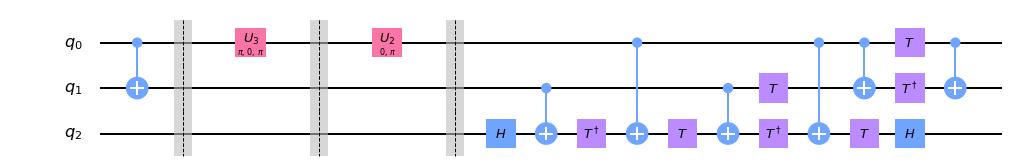

In [6]:
cost=QuantumCircuit(3)
cost.cx(0,1)
cost.barrier()
cost.x(0)
cost.barrier()
cost.h(0)
cost.barrier()
cost.ccx(0,1,2)
cost.decompose().draw('mpl')

And voila!

$\rightarrow$ The quantum cost of these gates are:

* Control Gate `cx` = $1$.
* Not Gate `x` = $1$.
* Hadamard Gate `h` = $1$.
* Toffoli Gate `ccx` = $15$.

**Each quantum computer model may have a different cost for a given quantum gate.**

As seen above There are in *Omar's* circuit: 

* $336$ Toffoli Gate `ccx`.
* $289$ Not Gate `x`.
* $201$ Hadamard Gate `h`.
* $24$ Control Gate `cx`.

$\rightarrow$ **Hence the quantum cost of that Omar's circuit is:**$$Quantum\;Cost = 15\times336 + 1\times289 + 1\times201 + 1\times24 = 5554.$$

Actually, let us decompose the circuit to the primitive gates (elementary gates), like the rotation gates U3 and the CNOT gate, then calculate the cost.

Any unitary operation can be replaced by a combination of controlled-NOT (CNOT) and single qubit gate, like U1,2,3 gates.

By using `qiskit.transpiler` and importing `PassManager`, we can decompose this circuit into U3 (`u3`) gates and CNOT (`cx`) gates using the qiskit tool `Unroller` program, as seen below:

In [10]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(circuit) 
new_circuit.count_ops()

OrderedDict([('u3', 3514), ('cx', 2040), ('measure', 8)])

Then, we remark that there are:

* $3514$ U3 Gate `u3`.
* $2040$ Ctrolled Gate `cx`.

$\rightarrow$ Therefore, the quantum cost of that circuit in this case is:$$Quantum\;Cost = 3514 + 2040= 5554.$$

Which is equal to what we achieved above.

Whereas, the CNOT gate is the most expensive gate to implement, wherein the current NISQ devises, the noise introduced implementing the CX gate is heavier.

Consequently, we may weigh CX gates more than a single-qubit gate for the cost evaluation.

**The lesser the quantum cost, the better the circuit.**

This leads me to write a code that has three advantageous characteristics compared to the above one and outperforms on it, [(see the code test)](https://github.com/moustafa-7/Grover-s-Algorithm-QOSF/blob/master/src/Grover/main.ipynb):

* It's a general code that accepts as input any string of a binary number to search for.

* The boolean oracle and diffuser operator are carried out in two different ways:

    1- An `'ancilla'` circuit; this one uses two-control Toffoli gates, thus the oracle will depends on ancillary qubits to be implemented, and its peculiarity lies in the diffuser operator, compared to Omar's one its gets rid of two Toffoli gates and uses instead two Hadamard gates, which is an advantage since the former is too expensive to implement.
    
    2- An `'noancilla'` circuit, uses multiple-control Toffoli gates instead of two-control Toffoli gates in both oracle and diffuser parts.
    
Let's see the difference between those circuits at the level of the quantum cost:

In [11]:
##################################  WALID'S CODE  ##################################

#### Same procedure to get the quantum cost:
Let's evaluate the `ancilla` circuit first:

In [13]:
ancilla_circuit, *_ =grover_itera(['01011001'], 'ancilla')
ancilla_circuit.decompose().count_ops()

OrderedDict([('ccx', 312),
             ('x', 288),
             ('h', 216),
             ('cx', 24),
             ('u2', 9),
             ('measure', 8),
             ('u3', 1)])

* $312$ Toffoli Gate `ccx`.
* $289$ Not Gate `x`= `u3(pi,0,pi)`.
* $225$ Hadamard Gate `h`=`u2(0,pi)`.
* $24$ Control Gate `cx`.

$\rightarrow$**Therefore, the cost of Walid's circuit is:**$$Quantum\;Cost = 15\times312 + 1\times289 + 1\times225 + 1\times24 = 5218.$$

$\Rightarrow$ **As we can see the cost has been decreased, this is due to the decrease of the costly two-qubits Toffoli gate.**

Without assessing the cost in the case of elementary gates, it turns out to be the same. However, this will be interesting in the case of `noancilla` circuit:

In [16]:
noancilla_circuit, *_ =grover_itera(['01011001'], 'noancilla')
# to elementary gates: u3 and cx
new_circuit = pm.run(noancilla_circuit) 
new_circuit.count_ops()

OrderedDict([('u3', 14314), ('cx', 13728), ('measure', 8)])

So, there are: 

* $14314$ U3 Gate `u3`.
* $13728$ Ctrolled Gate `cx`.

$\rightarrow$ **The cost is large:**$$Quantum\;Cost = 14314 + 13728= 28042.$$

$\Rightarrow$ **This leads to the conclusion that if you don't want to pay off on the number of qubits (circuit width), you are going to do so in the number of gates used (circuit depth)!**

Definitely there are many ways to implement Grover's circuit to come up with better ones; for instance, using the phase oracle reduces the number of qubits used. Hence Walid's code still under development.